In [52]:
import numpy as np
import urllib3 
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

## Import text file

In [53]:
# Grab text file from github
http = urllib3.PoolManager()
textfile = http.request('GET', 'https://raw.githubusercontent.com/nghess/makemore/master/names.txt')
words = str(textfile.data, 'utf-8').splitlines()

In [54]:
# Take a peak at text file
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [55]:
# Build character to/from string mappings
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
itos

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

In [56]:
block_size = 3 # Context length
X, Y = [], []
for w in words:
  #print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
   # print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] #  Crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

In [57]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
  p.requires_grad = True

In [58]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [75]:
lri = []
lossi = []

# Forward pass
for i in range(10000):

  # Minibatch construct
  ix = torch.randint(0, X.shape[0], (32,), generator=g)

  # Forward pass
  emb = C[X[ix]]  # (32, 2, 2) by indexing into the dataset 
  h = torch.tanh(emb.view(emb.shape[0], W1.shape[0]) @ W1 + b1)
  logits = h @ W2 + b2  # (32, 27)
  loss = F.cross_entropy(logits, Y[ix])

  # Backward pass
  for p in parameters:
      p.grad = None
  loss.backward()

  # Update
  #lr = lrs[i]
  lr = .01
  for p in parameters:
    p.data += -lr * p.grad

  # Track loss
  lri.append(lr)
  lossi.append(loss.item())

#print(loss.item())

In [76]:
emb = C[X]  # (32, 2, 2) by indexing into the dataset 
h = torch.tanh(emb.view(emb.shape[0], W1.shape[0]) @ W1 + b1)
logits = h @ W2 + b2  # (32, 27)
loss = F.cross_entropy(logits, Y)
loss

tensor(2.3272, grad_fn=<NllLossBackward0>)

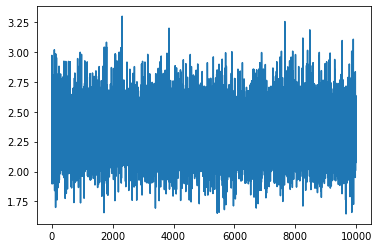

In [78]:
plt.plot(lossi)